In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
import os

from ucimlrepo import fetch_ucirepo

In [11]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

# Functions
- Data Processing Functions
- Exploratory Data Analysis (EDA) Functions

## Data Processing Functions
- load_data()
- get_test_and_training_data(test_size=0.2)

In [12]:
## groups are right now 'Nacionality' and 'Gender'
def load_data():
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
    df = predict_students_dropout_and_academic_success.data.features 
    
    data_y = predict_students_dropout_and_academic_success.data.targets
    data_y = data_y.Target.apply(lambda x: 1 if x == 'Dropout' else 0)

    df['Dropout'] = data_y
    #df_incl_curricular_units = df.copy()

    ## Remove Features related to Curricular units
    df = df[['Marital Status', 'Application mode', 'Application order', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Previous qualification (grade)',
           'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
           'Tuition fees up to date',
           'International', 'Unemployment rate',
           'Inflation rate', 'GDP', 
           "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation", 
           'Scholarship holder', 'Age at enrollment', 'Gender', 'Nacionality', 'Dropout']]
    
    features = df.drop('Dropout', axis=1)
    labels = df[['Dropout']]
    groups = df[['Nacionality', 'Gender']]
    
    return df, features, labels, groups#, df_incl_curricular_units

def get_test_and_training_data(features, labels, test_size=0.2):
    ## This code is adapted from solution to data debias exercises
    X = features.copy()
    y = labels.copy()
    
    # X_train = X_train.reset_index(drop=True) # doesn't seem to make a difference now
    # y_train = y_train.reset_index(drop=True) # doesn't seem to make a difference now

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # Subset for protected and non-protected features
    X_train_p = X_train.iloc[:, -2:]
    X_train_np = X_train.iloc[:, :-2]
    X_test_p = X_train.iloc[:, -2:]
    X_test_np = X_train.iloc[:, :-2]
    
    return X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np
    

## Exploratory Data Analysis (EDA) Functions
- corr_mat(X, method='pearson')
- plot_corr(df, method='pearson')

In [13]:
def corr_mat(X, method='pearson'):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the correlations, and their 
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    if method == 'pearson':
        corr_func = pearsonr
    elif method == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = corr_func(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

def plot_corr(df, method='pearson'):
    corr, p = corr_mat(df, method)
    
    alpha = 0.05 # Significance level
    corrected_alpha = alpha / (df.shape[1]**2/2) #bonferronni correction,
    
    plt.figure(figsize=(15,15))
    sns.heatmap(corr, cmap="coolwarm",
                xticklabels=df.columns, yticklabels=df.columns,
                square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)
    
    corr_name = ""
    if method == 'pearson':
        corr_name = "Pearson's "
    elif method == 'spearman':
        corr_name = "Spearman's "
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    plt.title(f"{corr_name}Correlation Coeff between all features (filtered by p > {alpha})")
    plt.show()

## Helper functions

In [14]:
def cross_validator(X, y, n=5):
    ''' Input:  X: training data
                y: true labels
                n: number of folds for cross validation, default=5
        Output: 2 dataframes, with accuracy and f1 scores, 
                per fold for overall and the 4 groups:
                male, female, white, african-american'''
    scaler = StandardScaler() ## We need to scale within the cross val step to avoid data leakage
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)

    kfold = KFold(n, shuffle=True, random_state=seed)
    
    X_np = X.iloc[:, :-2]
    X_p = X.iloc[:, -2:]

    accuracies = []
    f1 = []
    X = np.array(X_np).reshape(-1, X_np.shape[1])
    X_p=np.array(X_p).reshape(-1, X_p.shape[1])
    y = np.array(y).reshape(-1, 1)

    for train_idx, test_idx in kfold.split(X):
        pipe = make_pipeline(scaler, cls)
        acc = []
        f1s = []
        X_train = X[train_idx]
        y_train = y[train_idx].astype(bool)
        X_test  = X[test_idx]
        y_test  = y[test_idx].astype(bool)
        X_p_test= X_p[test_idx]



        pipe.fit(X_train, y_train.ravel())
        y_hat = pipe.predict(X_test)
        print("y_test:")
        print(type(y_test))
        print("Size of the y_test:", y_test.size)
        print(y_test)
        print("y_hat:")
        print(type(y_hat))
        print("Size of the y_hat:", y_hat.size)
        print(y_hat)

        acc

        acc.append(accuracy_score(y_test, y_hat))
        f1s.append(f1_score(y_test, y_hat))
        
        for i in [0,1]:
            for j in [0,1]:
                acc.append(accuracy_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)
    return pd.DataFrame(accuracies, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(f1, columns=['General','Male','Female','White','AA'])

# Try things out...

In [15]:
df, features, labels, groups = load_data() 
X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np = get_test_and_training_data(features, labels)

In [16]:
print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("Nacionality" in f) or ("Gender" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 22 (Gender)
Column ID: 23 (Nacionality)


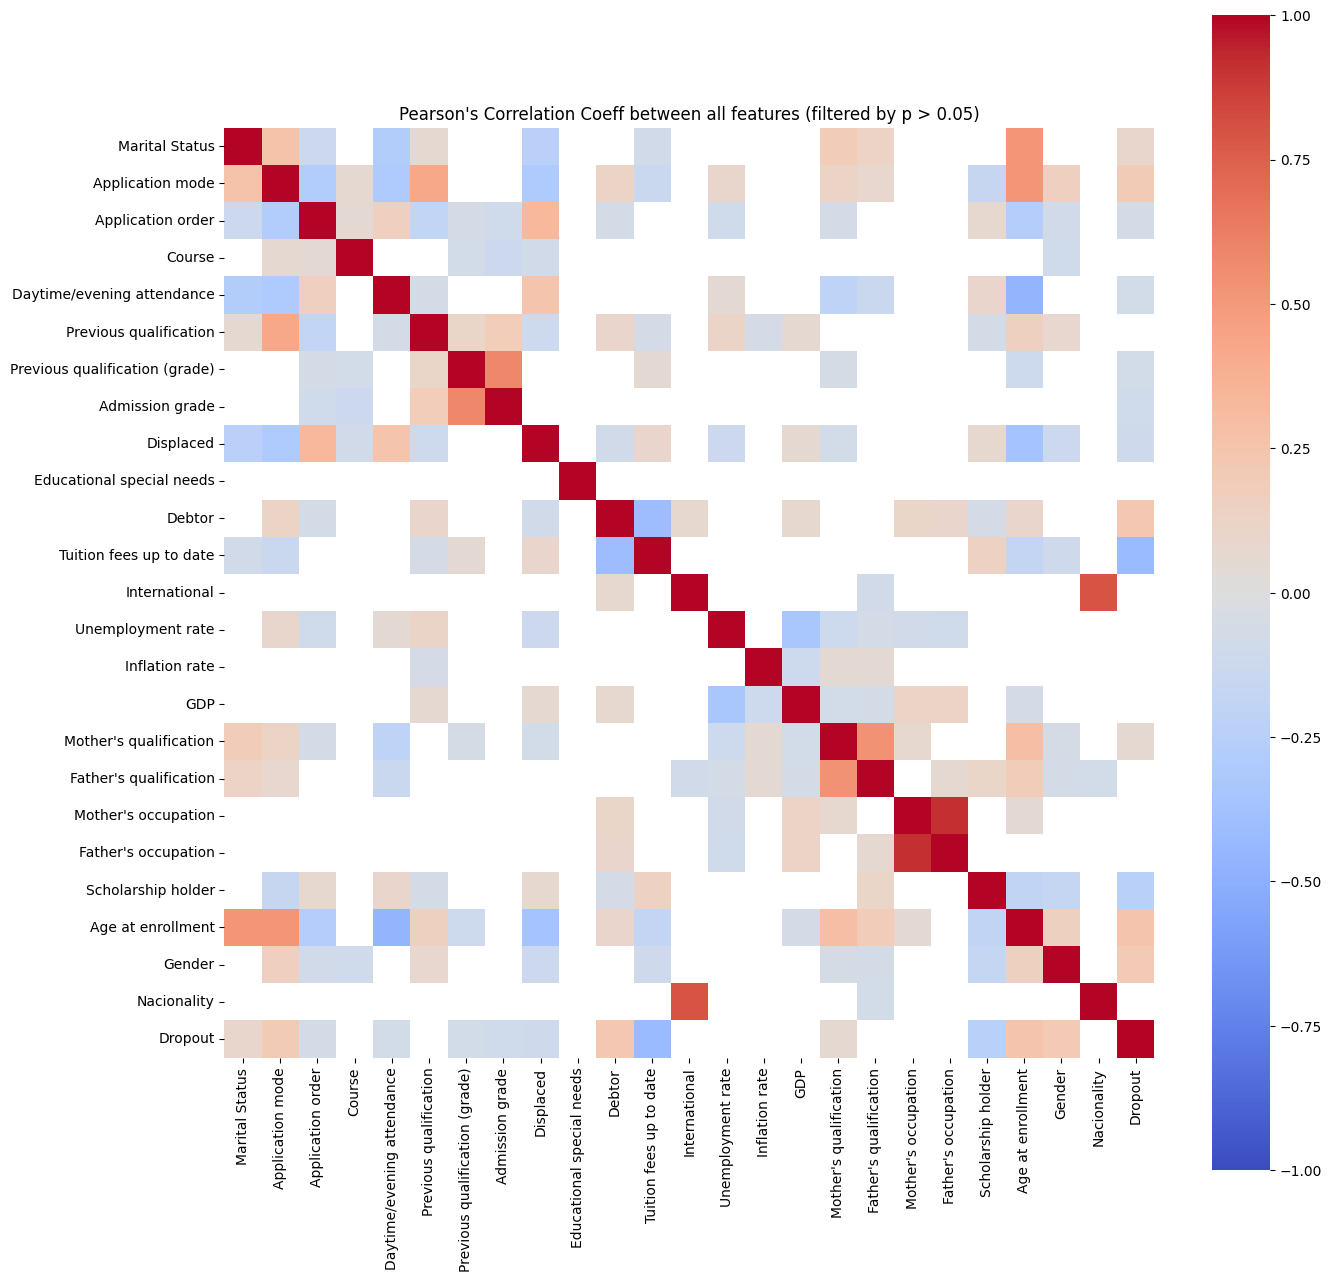

In [17]:
plot_corr(df)

In [ ]:
accs, f1s = cross_validator(X_train, y_train)

pd.DataFrame([accs.mean(), f1s.mean()], index=['Accuracy', 'F1']).T.round(4)